In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

import itertools
import seaborn as sns
from sklearn import metrics

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Now you can use the file path to access specific files
file_path = '/content/drive/MyDrive/gpt fakearticles/Fake.csv'  # Replace with your file's path
file_path = '/content/drive/MyDrive/gpt fakearticles/True.csv'
# You can then open and read the file as you would with a local file
with open(file_path, 'r') as file:
    content = file.read()

print(content)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
df_true1 = pd.read_csv("/content/drive/MyDrive/gpt fakearticles/True.csv")
df_fake1 = pd.read_csv("/content/drive/MyDrive/gpt fakearticles/Fake.csv")

In [4]:
print(df_true1["text"][0])

WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educati

In [5]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()

In [6]:
fake_articlesdf = pd.read_csv("/content/drive/MyDrive/gpt fakearticles/chatgpt_fake_articles (1).csv", encoding='unicode_escape')

fake_articles = fake_articlesdf["text"].to_list()

fake_articlesdf2 = pd.read_csv("/content/drive/MyDrive/gpt fakearticles/chatgpt_fake_articles.csv", encoding='unicode_escape')

fake_articles2 = fake_articlesdf2["text"].to_list()



true_titles = df_true1["text"].to_list()

fake_titles = df_fake1["text"].to_list()

texts = true_titles + fake_titles + fake_articles

#add a new dataset to this one to test (so the tokenizer has seen the words before)
textswithfakearticles = true_titles + fake_titles + fake_articles + fake_articles2

# Create labels
true_labels = [1] * len(true_titles)
fake_labels = [0] * len(fake_titles)
fake_article_labels = [0] * len(fake_articles)

labels = true_labels + fake_labels + fake_article_labels


tokenizer.fit_on_texts(textswithfakearticles)

tokenized = tokenizer.texts_to_sequences(texts)



print(max(tokenizer.word_index.values()))

vocab_size = max(tokenizer.word_index.values())+1

print(vocab_size)


#print(tokenized)

print(len(tokenized))
print(len(labels))

138053
138054
44948
44948


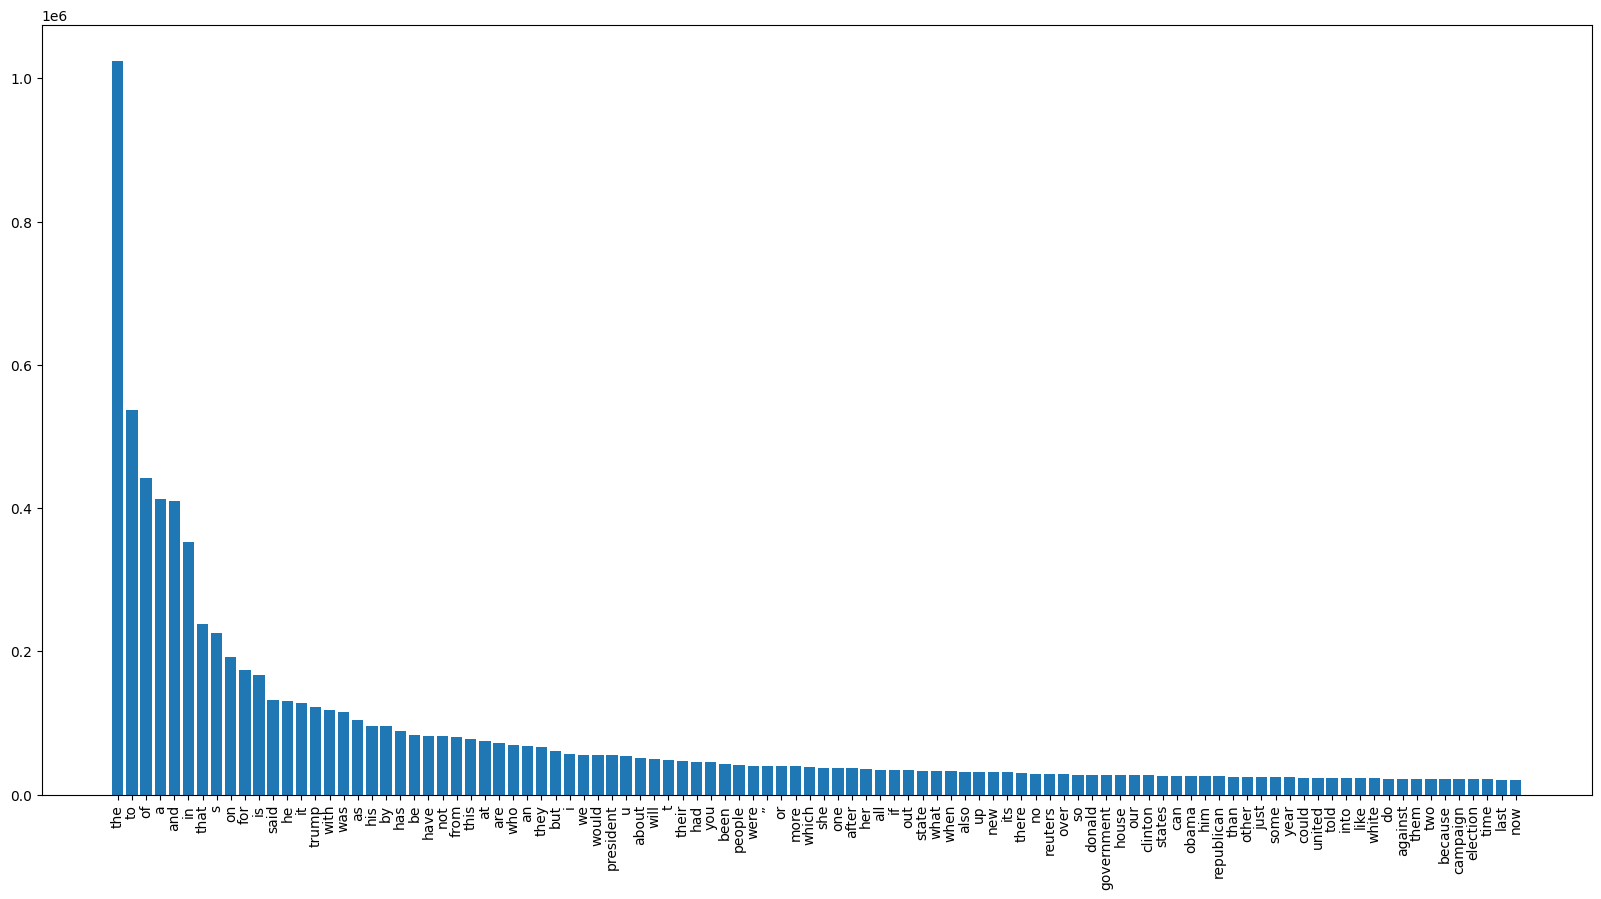

In [7]:
word_counts = tokenizer.word_counts
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
most_common_words = sorted_word_counts[:100]
words, counts = zip(*most_common_words)
plt.figure(figsize=(20,10))
plt.bar(words, counts)
plt.xticks(rotation='vertical')
plt.show()

Distribution of article lengths


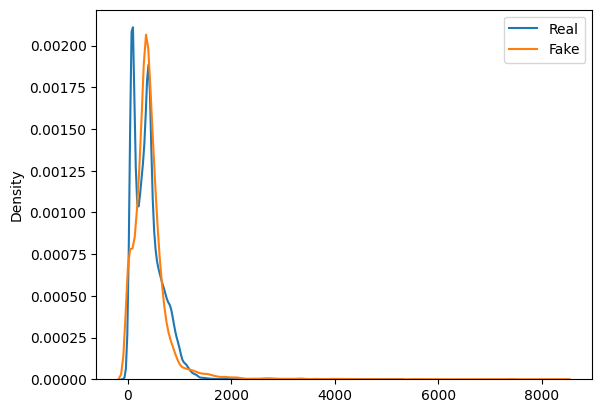

In [8]:
lengths = [len(item) for item in tokenized]

max_length = max(lengths)
min_length = min(lengths)

max_length_index = lengths.index(max_length)
min_length_index = lengths.index(min_length)

true_tokenized = tokenizer.texts_to_sequences(true_titles)

fake_tokenized = tokenizer.texts_to_sequences(fake_titles)

true_lengths = [len(item) for item in true_tokenized]

fake_lengths = [len(item) for item in fake_tokenized]

print("Distribution of article lengths")

#sns.kdeplot(lengths, label='Overall')
sns.kdeplot(true_lengths, label='Real')
sns.kdeplot(fake_lengths, label='Fake')

plt.legend()
plt.show()

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


padded_sequences = pad_sequences(tokenized, padding='post', maxlen=max_length)

print(padded_sequences)

lengths = [len(item) for item in padded_sequences]

max_length = max(lengths)
min_length = min(lengths)

max_length_index = lengths.index(max_length)
min_length_index = lengths.index(min_length)

[[ 107   67    1 ...    0    0    0]
 [ 107   67 1549 ...    0    0    0]
 [ 107   67    1 ...    0    0    0]
 ...
 [   1   15  155 ...    0    0    0]
 [   1  163   21 ...    0    0    0]
 [   1   15  155 ...    0    0    0]]


1/1 [==============================] - 5s 5s/step
(32, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8375, 44)          6074376   
                                                                 
 bidirectional (Bidirection  (None, 512)               616448    
 al)                                                             
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 6822666 (26.03 MB)
Trainable params: 6822666 (26.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


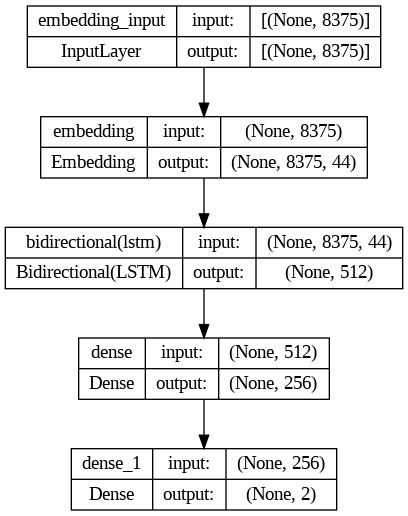

In [10]:
embedding_length = 44

from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * (10**(-epoch/2))
callbacks = [LearningRateScheduler(scheduler, verbose=1)]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_length, input_length=max_length))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences = False)))

model.add(tf.keras.layers.Dense(256, activation = "relu"))

model.add(tf.keras.layers.Dense(2, activation = "softmax"))
input_array = np.random.randint(1000, size=(32, max_length))
model.compile(tf.keras.optimizers.AdamW(weight_decay=0.001), 'binary_focal_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
output_array = model.predict(input_array)
print(output_array.shape)
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [11]:
print(padded_sequences[20])

[107  67   4 ...   0   0   0]


In [12]:
labels = np.array(labels)

one_hot_labels = to_categorical(labels)

print(one_hot_labels[0])

sequences_train, sequences_test, labels_train, labels_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=43)

model.fit(sequences_train, labels_train, epochs = 4, batch_size = 64, validation_data=(sequences_test, labels_test), callbacks=callbacks)
model.evaluate(sequences_test, labels_test)

[0. 1.]

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/4
562/562 [==============================] - 698s 1s/step - loss: 0.0090 - binary_accuracy: 0.9885 - val_loss: 7.6620e-04 - val_binary_accuracy: 0.9992 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.00031622778103685084.
Epoch 2/4
562/562 [==============================] - 691s 1s/step - loss: 2.8939e-04 - binary_accuracy: 0.9998 - val_loss: 7.4421e-04 - val_binary_accuracy: 0.9992 - lr: 3.1623e-04

Epoch 3: LearningRateScheduler setting learning rate to 3.162277862429619e-05.
Epoch 3/4
562/562 [==============================] - 683s 1s/step - loss: 1.1613e-04 - binary_accuracy: 0.9999 - val_loss: 6.8884e-04 - val_binary_accuracy: 0.9992 - lr: 3.1623e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.0000000409520217e-06.
Epoch 4/4
281/281 [==============================] - 81s 286ms/step - loss: 6.8809e-04 - binary_accuracy: 0.9992


[0.0006880914443172514, 0.9992213845252991]

281/281 [==============================] - 80s 285ms/step - loss: 6.8809e-04 - binary_accuracy: 0.9992
Accuracy: 99.92%
confusion matrix,without normalization


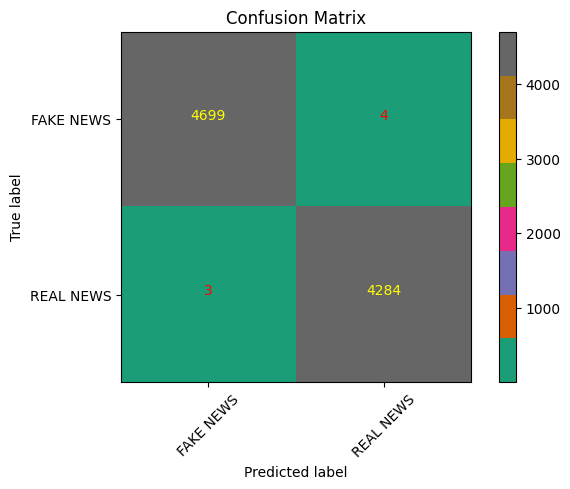

In [13]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Dark2):
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes)
  if normalize:
    cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("normalize confusion matrix")
  else:
    print('confusion matrix,without normalization')

  thresh = cm.max() / 2
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="yellow" if cm[i, j] > thresh else "red")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

pred_lr=model.predict(sequences_test)
score = model.evaluate(sequences_test, labels_test)
pred_lr = (pred_lr > 0.5).astype(int)
labels_test_single = np.argmax(labels_test, axis=1)
pred_lr_single = np.argmax(pred_lr, axis=1)
print(f'Accuracy: {round(score[1]*100,2)}%')
cm = metrics.confusion_matrix(labels_test_single,pred_lr_single)
plot_confusion_matrix(cm, classes=['FAKE NEWS', 'REAL NEWS'])

In [14]:
misclassified_indices = np.where(pred_lr_single != labels_test_single)[0]

incorrect_labels = []
for i in misclassified_indices:
    incorrect_labels.append(pred_lr_single[i])

misclassified_sequences = []
for i in misclassified_indices:
    misclassified_sequences.append(sequences_test[i])
misclassified_texts = tokenizer.sequences_to_texts(misclassified_sequences)

for i in range(len(misclassified_texts)):
    if incorrect_labels[i] == 1:
        print("Predicted Real\n")
    if incorrect_labels[i] == 0:
        print("Predicted Fake\n")
    print(misclassified_texts[i])
    print()



Predicted Real

according to reuters a grand jury in oklahoma found that jail staff did not verify what drugs they were using for lethal injections and were unaware when the wrong drugs were administered this report is another damning piece of evidence that shows that there are many flaws in the supposedly humane systems in place for carrying out capital punishments in 2014 the news broke that the execution of an inmate named clayton lockett who was sentenced to death for murder an executioner failed to properly put an i v line into lockett the needle used to inject the lethal drugs into lockett began to spray all over the execution chamber that he was in he died after 45 minutes of agony not because the toxins that were pumped into his body worked as intended but because they caused lockett to die of a heart attack after a massive outcry from the public which included a scathing condemnation from amnesty international oklahoma made some minor changes to their policies regarding execut

In [15]:
position = 21416

position = 21417

input_array=padded_sequences[position]
print(texts[position])
print(input_array)

input_array = np.expand_dims(input_array, 0)
print(input_array)

output_array = model.predict(input_array)
print(output_array)

Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t eve

# ANN

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

In [17]:
lengths = []

for i in range(len(tokenized)):

    lengths.append(len(tokenized[i]))


print(max(lengths))

print(min(lengths))

8375
0


In [18]:
lengths = [len(item) for item in tokenized]

max_length = max(lengths)
min_length = min(lengths)

max_length_index = lengths.index(max_length)
min_length_index = lengths.index(min_length)

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming sequences is your list of lists, where each inner list is a sequence.
sequences = [[1, 2, 3], [4, 5], [6, 7, 8, 9]]

# Pad the sequences
padded_sequences = pad_sequences(sequences, padding='post')

print(padded_sequences)

[[1 2 3 0]
 [4 5 0 0]
 [6 7 8 9]]


In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


padded_sequences = pad_sequences(tokenized, padding='post')

print(padded_sequences)

lengths = [len(item) for item in padded_sequences]

max_length = max(lengths)
min_length = min(lengths)

max_length_index = lengths.index(max_length)
min_length_index = lengths.index(min_length)

[[ 107   67    1 ...    0    0    0]
 [ 107   67 1549 ...    0    0    0]
 [ 107   67    1 ...    0    0    0]
 ...
 [   1   15  155 ...    0    0    0]
 [   1  163   21 ...    0    0    0]
 [   1   15  155 ...    0    0    0]]


1/1 [==============================] - 0s 109ms/step
(32, 2)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8375, 44)          6074376   
                                                                 
 dense_2 (Dense)             (None, 8375, 256)         11520     
                                                                 
 dense_3 (Dense)             (None, 8375, 256)         65792     
                                                                 
 global_average_pooling1d (  (None, 256)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_4 (Dense)             (None, 2)                 514       
                                                                 
Total params: 6152202 (23.47 MB)
Trainable params: 6152202 

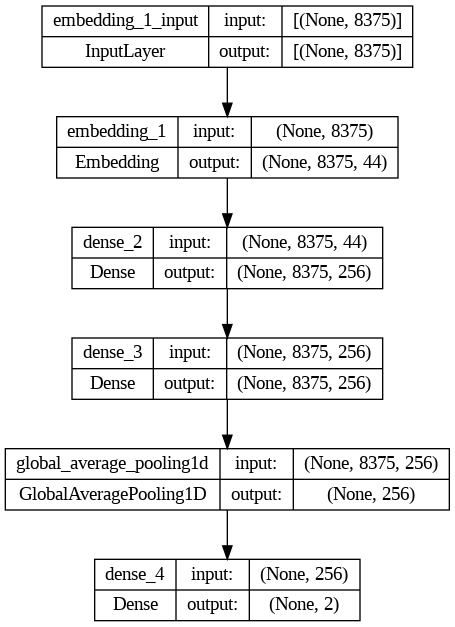

In [21]:
embedding_length = 44


model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_length, input_length=max_length))

model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(2, activation = "softmax"))
input_array = np.random.randint(1000, size=(32, max_length))
model.compile(tf.keras.optimizers.AdamW(), 'binary_focal_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()])
output_array = model.predict(input_array)
print(output_array.shape)
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [22]:
print(padded_sequences[20])

[107  67   4 ...   0   0   0]


In [ ]:
labels = np.array(labels)

one_hot_labels = to_categorical(labels)

print(one_hot_labels[0])

sequences_train, sequences_test, labels_train, labels_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)


model.fit(sequences_train, labels_train, epochs = 4, batch_size = 256, validation_data=(sequences_test, labels_test))
model.evaluate(sequences_test, labels_test)

[0. 1.]


In [ ]:
position = 21416

position = 21417

input_array=padded_sequences[position]
print(texts[position])
print(input_array)

input_array = np.expand_dims(input_array, 0)
print(input_array)

output_array = model.predict(input_array)
print(output_array)

In [ ]:
hard_test = tokenizer.texts_to_sequences(fake_articles2)

padded_fake_articles = pad_sequences(hard_test, padding='post', maxlen=8375)

In [ ]:
#positions = [1,2,3,4,5,6,7,8]
for position in range(len(padded_fake_articles)):
    input_array=padded_fake_articles[position]
    print(fake_articles[position])
    #print(input_array)

    input_array = np.expand_dims(input_array, 0)
    #print(input_array)

    output_array = model.predict(input_array)
    print(output_array)

In [ ]:
hard_test_labels = [0] * len(padded_fake_articles)

hard_test_labels = [1] + hard_test_labels

hard_test_labels = np.array(hard_test_labels)

one_hot_hard_test_labels = to_categorical(hard_test_labels)

one_hot_hard_test_labels = np.delete(one_hot_hard_test_labels, 0, axis=0)


#print(one_hot_hard_test_labels)

model.evaluate(padded_fake_articles, one_hot_hard_test_labels)

# RNN

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
plt.style.use('ggplot')

In [ ]:
fake_df = pd.read_csv('/content/drive/MyDrive/gpt fakearticles/Fake.csv')
real_df = pd.read_csv('/content/drive/MyDrive/gpt fakearticles/True.csv')

In [ ]:
fake_df.isnull().sum()

In [ ]:
real_df.isnull().sum()

In [ ]:
fake_df.subject.unique()

In [ ]:
real_df.subject.unique()

In [ ]:
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)

In [ ]:
fake_df['class'] = 0
real_df['class'] = 1

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)


total_len = len(fake_df) + len(real_df)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df) / total_len, color='orange')
plt.bar('Real News', len(real_df) / total_len, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)

In [ ]:
print('Difference in news articles:',len(fake_df)-len(real_df))

In [ ]:
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df

In [ ]:
#Combining the title with the text
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

In [ ]:
#Split into training and testing
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [ ]:
#Normalizing
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [ ]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)


In [ ]:
#onvert text to vectors
# tokenize the text into vectors
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [ ]:
#Building the RNN.
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)